# Sentiment Analysis for TripAdvisor Reviews (ROW NYC Hotel)

This project aims to analyse the sentiments of reviews by hotel guests on TripAdvisor. The hotel that we will be looking at will be Row NYC Hotel in New York City. There are a total of 13465 reviews scraped from the website using Selenium (the code can be found on GitHub Repo titled - Scraping TripAdvisor Reviews using Selenium). 

For this section, classical machine learning models will be used to predict the sentiments of the reviews. 
The reviews will be classified into Positive, Negative and Neutral sentiments. As such. this would be a supervised multi-class classification model. 

**The flow of this notebook:** 

1. Import relevant libraries and dataset 
2. Basic data exploration and cleaning 
3. Text Pre-processing 
    - To lower case
    - Remove noise - punctuations, emoticons, accented words
    - Expand contractions 
    - Tokenisation
    - Stopword Removal ( remove 'Not' from stopword bag)
    - Stemming /lemmatization
    
    
4. Exploratory Data Analysis
    - Word Cloud 


5. Machine Learning Pre-Processing 
    - TFIDF Vectorizer
    
    
6. Machine Learning 

    - Naives Bayes
    - SVM
    - Log regresssion
    - Random Forest
    - XGBoost

## 1. Import Relevant Libraries and Dataset

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set_style('whitegrid')

import re
import string

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from cleantext import clean
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.summarization import keywords
from sklearn.feature_extraction.text import TfidfTransformer
import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors
from wordcloud import WordCloud
from pylab import rcParams
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

import pickle
import contractions
import unicodedata
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yeosi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yeosi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yeosi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yeosi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [45]:
df = pd.read_csv('Reviews TA.csv')

In [46]:
df

,Date,Title,Review,Rating
0,April 2022,Nice stay in the heart of NYC,Very good location. Reasonable price. The room...,4
1,December 2021,Modern and Clean,We stayed in this hotel just before Christmas ...,5
2,April 2022,"Mid range hotel, very strategic location",Pleasant staff and security in place. Stayed h...,4
3,April 2022,"Small, cramped","Pricing was okay. Very noisy, small room. The ...",2
4,April 2022,6 days of Terror,"Rooms are filthy, elevators are dangerous and ...",1
...,...,...,...,...
13460,February 2016,"Great Place, Great Location!",This was my first time to New York and we know...,4
13461,February 2016,Best Place to Stay!,This is a great place in Time Square area to s...,5
13462,February 2016,"Great hotel, excellent location and great serv...",This was my first time visiting this hotel and...,4
13463,March 2016,Impressed! Happy!,"Not my first time in NYC, but it's my first ti...",4


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13465 entries, 0 to 13464
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    13465 non-null  object
 1   Title   13464 non-null  object
 2   Review  13465 non-null  object
 3   Rating  13465 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 420.9+ KB


## 2. Basic Data Exploration and Cleaning 

We only need the Review and Rating columns for the machine learning process, therefore, we shall remove the Date and Title Columns

In [60]:
# drop Date and Title columns 
df.drop(['Date', 'Title'], axis = 1, inplace = True)

In [5]:
df

,Review,Rating
0,Very good location. Reasonable price. The room...,4
1,We stayed in this hotel just before Christmas ...,5
2,Pleasant staff and security in place. Stayed h...,4
3,"Pricing was okay. Very noisy, small room. The ...",2
4,"Rooms are filthy, elevators are dangerous and ...",1
...,...,...
13460,This was my first time to New York and we know...,4
13461,This is a great place in Time Square area to s...,5
13462,This was my first time visiting this hotel and...,4
13463,"Not my first time in NYC, but it's my first ti...",4


In [6]:
df['Review'].iloc[100]
# Emoticons must be removed 

'I got charged for an upgrade.when I got to the room remind me of motel 6 no cooler, no coffee maker Old room paint stinks 🦨😩 A deluxe room!? Not worth it at all. Sorry but I was expecting something better for the price. Location not bad at all but it really needs some updates.'

[Text(0.5, 1.0, 'No. of Reviews per Rating')]

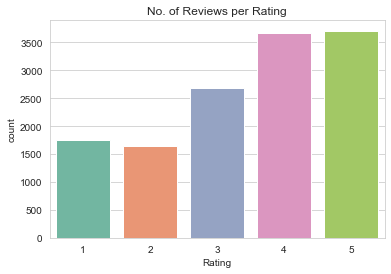

In [55]:
#Visualising the number of reveiws for each rating
sns.countplot(df['Rating'], palette = 'Set2').set(title = 'No. of Reviews per Rating')


- Reviews rated 1 or 2 will be labeled as Negative
- Reviews rated 3 will be labeled as Neutral
- Reviews rated 4 or 5 will be labeled as Positive

In [57]:
df['Polarity_Rating'] = df['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

[Text(0.5, 1.0, 'No of Reviews for each Polarity Rating')]

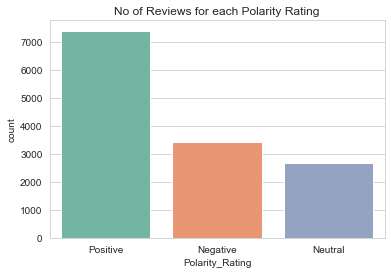

In [58]:
# Visualise the numbe rof reviews for each polarity rating 
sns.countplot(df['Polarity_Rating'], palette = 'Set2').set(title = 'No of Reviews for each Polarity Rating')

In [10]:
df['Polarity_Rating'].value_counts()

Positive    7388
Negative    3401
Neutral     2676
Name: Polarity_Rating, dtype: int64

In [61]:
df.head()

,Review,Rating,Polarity_Rating
0,Very good location. Reasonable price. The room...,4,Positive
1,We stayed in this hotel just before Christmas ...,5,Positive
2,Pleasant staff and security in place. Stayed h...,4,Positive
3,"Pricing was okay. Very noisy, small room. The ...",2,Negative
4,"Rooms are filthy, elevators are dangerous and ...",1,Negative


In [62]:
# drop Rating columns 
df.drop(['Rating'], axis = 1, inplace = True)

In [64]:
df.head()

,Review,Polarity_Rating
0,Very good location. Reasonable price. The room...,Positive
1,We stayed in this hotel just before Christmas ...,Positive
2,Pleasant staff and security in place. Stayed h...,Positive
3,"Pricing was okay. Very noisy, small room. The ...",Negative
4,"Rooms are filthy, elevators are dangerous and ...",Negative


As there is an imbalance in the number of reviews for each label, we will need to do resampling to address this problem. 
All labels will be resampled to 4000 reviews each. 

In [65]:
df_positive = df.loc[df['Polarity_Rating']== 'Positive'].sample(4000, replace=False)
df_neutral = df.loc[df['Polarity_Rating']== 'Neutral']
df_negative = df.loc[df['Polarity_Rating']== 'Negative']

In [66]:
df_neutral = df.loc[df['Polarity_Rating']== 'Neutral'].sample(4000, replace=True)
df_negative = df.loc[df['Polarity_Rating']== 'Negative'].sample(4000, replace=True)

In [67]:
df = pd.concat([df_positive, df_neutral, df_negative])

In [69]:
df

,Review,Polarity_Rating
6233,Really well located! Good price! Everything is...,Positive
7977,"Literally round the corner from Times Square, ...",Positive
5359,"Row NYC was a great surprise, excellent servic...",Positive
1241,The location of the hotel is great. the rooms ...,Positive
7799,I don't know what more to say? It was my first...,Positive
...,...,...
6516,Lights & electrics not working & not fixed pro...,Negative
7450,Beware Room 1631. This room under motor room c...,Negative
7396,The staff was rude and the wait time was unbel...,Negative
6431,The only good thing I can say about this hotel...,Negative


Encode the labels - 0 for Negative , 1 for Neutral and 2 for Positive

In [19]:
# Do encoding for Polarity ratings 
df.loc[df['Polarity_Rating']== 'Negative', 'Polarity_Rating'] = 0

In [20]:
df.loc[df['Polarity_Rating']== 'Neutral', 'Polarity_Rating'] = 1

In [21]:
df.loc[df['Polarity_Rating']== 'Positive', 'Polarity_Rating'] = 2

In [22]:
df

,Review,Polarity_Rating
9926,I really enjoyed my stay at Row NYC. It is clo...,2
847,Excellent staff attention. Very attentive and ...,2
9558,"This hotel is very well located, close to Time...",2
7228,The location is great for the theatre. We were...,2
8319,"First stayed in this hotel 6 years ago, it's b...",2
...,...,...
11286,"Hotel is not good for family, we stayed for 3 ...",0
12995,"No amenities. Sketchy cable service, Charged f...",0
1127,"My husband and I stayed at this apparent ""4 st...",0
6959,This hotel is extremely disappointing. They ch...,0


## 3. Text Pre-Processing 

Download English Stopwords

In [15]:
stop_words = set(stopwords.words('english'))

# Remove word 'not' in stopwords as Not can depict emotions
stop_words.remove('not')

In [17]:
# Create a function to map Part of Speech tags to the tokens, this function will be used later in the preprocess_text function
def pos_tag_wordnet(tagged_tokens):
    tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
    new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), wordnet.NOUN))
                            for word, tag in tagged_tokens]
    return new_tagged_tokens

In [9]:
# Create a function to clean the data accordingly 
def preprocess_text(review):
    
    #Convert all to lowercase 
    review = review.lower() 
    
    # Remove all emoticons
    review = clean(review, no_emoji=True)
    
    # Remove punctuations 
    review = review.translate (str.maketrans('','', string.punctuation))
    
    # Remove accented characters
    review = unicodedata.normalize('NFKD', review).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Remove # and @
    review = re.sub(r'\@\w+|\#','',review)
    
    # Remove \n
    review = re.sub('\n', '', review)
    
    # Remove numbers
    review = re.sub('\w*\d\w*', '', review)
    
    # Expand Contractions
    review = contractions.fix(review)

    # Tokenise reviews
    review_token = word_tokenize(review)
    
    # Remove stopwords
    filtered_review = [word for word in review_token if word not in stop_words]
    
    #Stemming
    #ps = PorterStemmer()
    #stemmed_words = [ps.stem(w) for w in filtered_review]
    
    # lemmatizing - pos = 'a' means generate adjective lemmas 
    lemmatizer = WordNetLemmatizer()
    #lemma_words = [lemmatizer.lemmatize(w, pos= 'a') for w in filtered_review]
    tagged_tokens = nltk.pos_tag(filtered_review)
    wordnet_tokens = pos_tag_wordnet(tagged_tokens)
    lemmatized_text = ' '.join(lemmatizer.lemmatize(word, tag) for word, tag in wordnet_tokens)
 
    
    #return " ".join (lemmatized_text)
    return lemmatized_text

In [43]:
# Checking of the function works well
preprocess_text("Hi, I aren't as bad as you think")

'hi not bad think'

In [44]:
# Apply the function to the reviews 
df['Review'] = df['Review'].astype(str).apply(preprocess_text)

In [45]:
df['Review']

9926     really enjoy stay row nyc close close time squ...
847      excellent staff attention attentive helpful go...
9558     hotel well locate close time square room not b...
7228     location great theatre able get park coupon on...
8319     first stay hotel year ago nicely refurbish sin...
                               ...                        
11286    hotel not good family stay day dirty room cong...
12995    amenity sketchy cable service charge wifi stai...
1127     husband stay apparent star hotel wow not expec...
6959     hotel extremely disappointing cheat customer h...
9042     not fool nice lobby entrance bar citykitchen s...
Name: Review, Length: 12000, dtype: object

In [46]:
df

,Review,Polarity_Rating
9926,really enjoy stay row nyc close close time squ...,2
847,excellent staff attention attentive helpful go...,2
9558,hotel well locate close time square room not b...,2
7228,location great theatre able get park coupon on...,2
8319,first stay hotel year ago nicely refurbish sin...,2
...,...,...
11286,hotel not good family stay day dirty room cong...,0
12995,amenity sketchy cable service charge wifi stai...,0
1127,husband stay apparent star hotel wow not expec...,0
6959,hotel extremely disappointing cheat customer h...,0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 9926 to 9042
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review           12000 non-null  object
 1   Polarity_Rating  12000 non-null  object
dtypes: object(2)
memory usage: 281.2+ KB


In [48]:
# convert the datatype of Polarity_Rating to integer 
df['Polarity_Rating'] = df['Polarity_Rating'].astype('int64')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 9926 to 9042
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review           12000 non-null  object
 1   Polarity_Rating  12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 281.2+ KB


## 4. Exploratory Data Analysis

In [76]:
# Create dataframes for each polarity rating 
positive = df.loc[df['Polarity_Rating'] == 2, 'Review']
negative = df.loc[df['Polarity_Rating'] == 0, 'Review']
neutral = df.loc[df['Polarity_Rating'] == 1, 'Review']

We will now create word clouds for each label - Positive, Negative, Neutral. This will help us to identify the common words that can be seen for each review rating. 

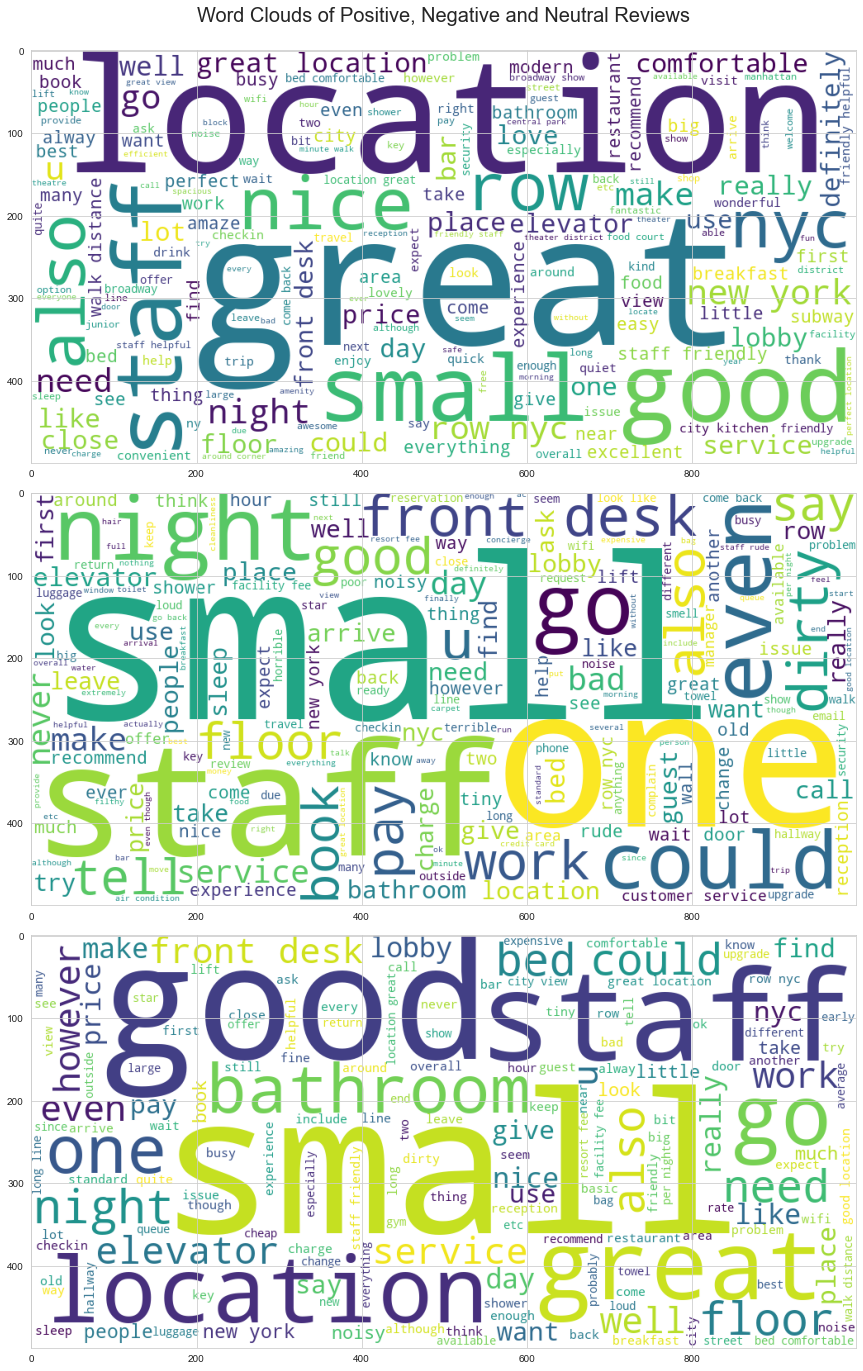

In [217]:
data = [positive,negative, neutral]
# Identify words that will be removed from word clouds as they are common words that are used in almost all reviews 
stopwords = ['hotel', 'room', 'stay', 'time', 'square','not', 'clean', 'get', 'check', 'would']

n=len(data)
fig,ax = plt.subplots(n ,1, figsize=(20, 20))

for i in range(n):
    plt.sca(ax[i])  #Set the current Axes to ax and the current Figure to the parent of ax
    col = data[i]
    
    word_cloud = ""
    for row in data[i]:
        for word in row:
            word_cloud+=" ".join(word)
    wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10, stopwords= stopwords).generate(word_cloud)
    plt.imshow(wordcloud)
    
    fig.suptitle (('Word Clouds of Positive, Negative and Neutral Reviews'), fontsize = 20)

    fig.tight_layout(rect=[0, 0.03, 1, 0.98])


As seen from the word clouds, positive reviews seem to focus on the great location, front-desk staff, price and experiences, while negative reviews seem to focus on bad service , noise-related problems and small and dirty rooms. 
Neutral reviews focus more on small rooms and great location, and there could also be some feedback on the price that was paid for the room as well as noise-related problems. 

## 5. Machine Learning

The classification algorithms to be used in this section would be: 

1. Logistic Regression
2. Random Forest Classifier
3. Multinomial Naives Bayes 
4. XGBoost
5. Support Vector Machine

For each iteration, TfidfVectorizer will be used to vectorise the words before it goes into the machine learning process. 
Hyperparameter tuning will also be done for potential models. The best model will then selected. 

In [51]:
# Do stratified train-test-split for the dataset 
X = df["Review"]
y = df.drop("Review", axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
, stratify = y)

In [52]:
X_train

5207     spent night biz trip choose basically location...
13234    stay multiple time construction stay enjoyable...
6768     row hotel choose location cost happy choice co...
2278     hey great location great service row nyc indee...
4524     dark dated hotel good location small room quit...
                               ...                        
13266    fantastic fun hotel right time square service ...
5257     checkin complicate employee speak portuguese a...
12387    book trip american express arrive hotel state ...
6616     hotel not change much year since last visited ...
6352     please ensure not hire staff good threatening ...
Name: Review, Length: 8400, dtype: object

### 1. Logistic Regression 

In [53]:
# Create a pipeline to vectorize the words which will be fed into the classification model 
pipe = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, sublinear_tf = True)),
 ('classifier', LogisticRegression(solver = 'liblinear', class_weight = 'balanced'))])

In [54]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, sublinear_tf=True)),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])

In [55]:
y_pred = pipe.predict(X_test)
y_pred

array([1, 2, 1, ..., 0, 0, 1], dtype=int64)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1200
           1       0.71      0.63      0.67      1200
           2       0.83      0.84      0.83      1200

    accuracy                           0.77      3600
   macro avg       0.77      0.77      0.77      3600
weighted avg       0.77      0.77      0.77      3600



We will be looking at accuracy for evaluation metrics. Accuracy results are pretty reasonable in this case. 

[[1030  132   38]
 [ 274  752  174]
 [  28  168 1004]]


<AxesSubplot:>

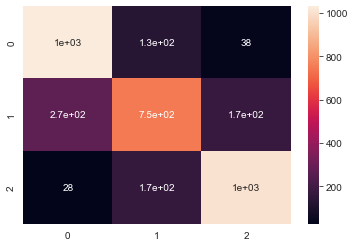

In [57]:
cm= confusion_matrix(y_test, y_pred)  

print(cm)

sns.heatmap(cm, annot=True)

The model does not seem to do very well in identifying the neutral reviews. So we will go ahead to do hyperparameter tuning to see if the results will improve further. 

### Hyperparameter Tuning for Logistic Regression

In [58]:
#GridSearchCV with a transformer and a estimator
parameters = {'vectorizer__max_df': [0.8,0.9],     
              'vectorizer__min_df' : [20,50,0.1,1],
              'classifier__C': [100, 10, 1.0, 0.1, 0.01],                                              
              'classifier__penalty':['l1','l2']}

gs=GridSearchCV(pipe, param_grid=parameters, cv = 5, verbose = 1)
#fit the training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  8.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        sublinear_tf=True)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [100, 10, 1.0, 0.1, 0.01],
                         'classifier__penalty': ['l1', 'l2'],
                         'vectorizer__max_df': [0.8, 0.9],
                         'vectorizer__min_df': [20, 50, 0.1, 1]},
             verbose=1)

In [59]:
gs.best_params_

{'classifier__C': 10,
 'classifier__penalty': 'l2',
 'vectorizer__max_df': 0.8,
 'vectorizer__min_df': 1}

In [73]:
cv = StratifiedKFold(n_splits=5, random_state= 42)
scores = cross_val_score(gs, X_train, y_train, cv=cv, n_jobs=-1)
print('Mean accuracy-Score: %.4f' % np.mean(scores))

Mean accuracy-Score: 0.7588


In [60]:
y_pred = gs.predict(X_test)

In [61]:
y_pred

array([0, 2, 1, ..., 0, 0, 1], dtype=int64)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1200
           1       0.76      0.78      0.77      1200
           2       0.87      0.83      0.85      1200

    accuracy                           0.82      3600
   macro avg       0.83      0.82      0.82      3600
weighted avg       0.83      0.82      0.82      3600



[[1041  122   37]
 [ 156  932  112]
 [  26  179  995]]


<AxesSubplot:>

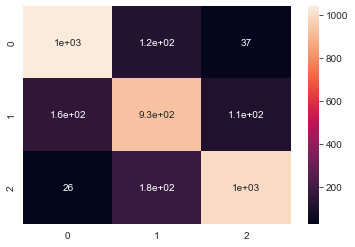

In [63]:
cm= confusion_matrix(y_test, y_pred)  

print(cm)

sns.heatmap(cm, annot=True)

The improved model seems to be doing better at identifying neutral reviews.

### 2. Random Forest Classifier

In [81]:
# Create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, sublinear_tf = True)),
 ('classifier', RandomForestClassifier(max_depth=50, random_state=42, class_weight = 'balanced'))])

In [82]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, sublinear_tf=True)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        random_state=42))])

In [83]:
# Cross-validation on training set to prevent overfitting 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state= 42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=-1)
print('Mean accuracy-Score: %.4f' % np.mean(scores))

Mean accuracy-Score: 0.8150


In [84]:
y_pred = pipe.predict(X_test)
y_pred

array([0, 2, 1, ..., 0, 0, 1], dtype=int64)

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1200
           1       0.89      0.75      0.81      1200
           2       0.84      0.89      0.86      1200

    accuracy                           0.85      3600
   macro avg       0.85      0.85      0.85      3600
weighted avg       0.85      0.85      0.85      3600



Results are pretty good for this model. Accuracy score is good at 0.85 and teh model seems to be doing even better at identifying neutral reviews compared to the logistic regression model. 

### Hyperparameter tuning for Random Forest Classifier 

In [92]:
parameters = {'vectorizer__max_df': [0.8,0.9], 
              'vectorizer__min_df' : [20,0.1,1],
              'classifier__n_estimators': [200, 150,100,75,50, 10],                                               #np.logspace(-3,3,7),,
             'classifier__max_features': ['auto', 'sqrt', 'log2']}

gs=GridSearchCV(pipe, param_grid=parameters, cv = 3, verbose = 1)
#fit the training data
gs.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed: 47.1min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        sublinear_tf=True)),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=50,
                                                               random_state=42))]),
             param_grid={'classifier__max_features': ['auto', 'sqrt', 'log2'],
                         'classifier__n_estimators': [200, 150, 100, 75, 50,
                                                      10],
                         'vectorizer__max_df': [0.8, 0.9],
                         'vectorizer__min_df': [20, 0.1, 1]},
             verbose=1)

In [86]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'classifier', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__norm', 'vectorizer__preprocessor', 'vectorizer__smooth_idf', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__sublinear_tf', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__use_idf', 'vectorizer__vocabulary', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_impurity_split', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__n_est

In [93]:
y_pred = gs.predict(X_test)

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87      1200
           1       0.90      0.75      0.82      1200
           2       0.85      0.89      0.87      1200

    accuracy                           0.86      3600
   macro avg       0.86      0.86      0.85      3600
weighted avg       0.86      0.86      0.85      3600



Accuracy score increased by 0.1, and the rest of the scores remain largely similar after tuning. 

### 3. Multinomial Naives Bayes

In [67]:
pipe = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, sublinear_tf = True)),
 ('classifier', MultinomialNB())])

In [68]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, sublinear_tf=True)),
                ('classifier', MultinomialNB())])

In [69]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state= 42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=-1)
print('Mean accuracy-Score: %.4f' % np.mean(scores))

Mean accuracy-Score: 0.7523


In [70]:
y_pred = pipe.predict(X_test)
y_pred

array([0, 2, 2, ..., 0, 0, 1], dtype=int64)

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1200
           1       0.69      0.68      0.69      1200
           2       0.84      0.80      0.82      1200

    accuracy                           0.77      3600
   macro avg       0.77      0.77      0.77      3600
weighted avg       0.77      0.77      0.77      3600



Accuracy score for Multinomial Naives Bayes model is not as good compared to Rnadom Forest Classifier. The model also seem to have difficulties in identifying the neutral reviews. 

### 4. XGBoost 

In [81]:
pipe = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, sublinear_tf = True)),
 ('classifier', XGBClassifier(objective='multi:softprob', random_state = 42, num_class = 3))])

In [82]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, sublinear_tf=True)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_class=3,
                               num_parall

In [83]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state= 42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=-1)
print('Mean accuracy-Score: %.4f' % np.mean(scores))

Mean accuracy-Score: 0.8052


In [84]:
y_pred = pipe.predict(X_test)
y_pred

array([0, 2, 2, ..., 0, 0, 1], dtype=int64)

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1200
           1       0.76      0.78      0.77      1200
           2       0.87      0.82      0.84      1200

    accuracy                           0.82      3600
   macro avg       0.82      0.82      0.82      3600
weighted avg       0.82      0.82      0.82      3600



Results for XGBoost model seems to pretty similar to the Logistic Regression model (with hyperparameter tuning). Up to this point, the best model is still Random Forest Classifier (with tuning). We shall move on to see if Support Vector Machine will give us better results. 

### 5. SVM 

In [104]:
pipe = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, sublinear_tf = True)),
 ('classifier', SVC(probability=True, random_state = 42, class_weight= 'balanced'))])

In [105]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, sublinear_tf=True)),
                ('classifier',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

In [88]:
cv = StratifiedKFold(n_splits=5, random_state= 42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=-1)
print('Mean accuracy-Score: %.4f' % np.mean(scores))

Mean accuracy-Score: 0.8307


In [106]:
y_pred = pipe.predict(X_test)
y_pred

array([0, 2, 1, ..., 0, 0, 1], dtype=int64)

In [107]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.88      1200
           1       0.80      0.81      0.80      1200
           2       0.90      0.85      0.87      1200

    accuracy                           0.85      3600
   macro avg       0.85      0.85      0.85      3600
weighted avg       0.85      0.85      0.85      3600



Accuracy score is similar to Random Forest Classification model, with good precision and recall for all labels. Let us explore if hyperparameter tuning will improve the performace of the model. 

### Hyper-parameter tuning for SVM

In [109]:
# define model and parameters
pipe = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, sublinear_tf = True)),
 ('classifier', SVC(probability=True, random_state = 42, class_weight= 'balanced'))])
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale', 'auto']
parameters = {'vectorizer__max_df': [0.8,0.9], 
              'vectorizer__min_df' : [20,0.1,1],
             'classifier__kernel': kernel,
              'classifier__C': C,
             'classifier__gamma': gamma}

# define grid search
#grid = dict(classifier__kernel=kernel,classifier__C=C,classifier__gamma=gamma)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator= pipe, param_grid= parameters, n_jobs=-1, cv=3,error_score=0, verbose = 1)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 60.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 141.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 178.8min finished


Best: 0.810119 using {'classifier__C': 1.0, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly', 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 20}


In [219]:
estimator = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, sublinear_tf = True)),
 ('classifier', SVC(probability=True, random_state = 42, class_weight= 'balanced'))])
# the parameters that can be tuned 
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'classifier', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__norm', 'vectorizer__preprocessor', 'vectorizer__smooth_idf', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__sublinear_tf', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__use_idf', 'vectorizer__vocabulary', 'classifier__C', 'classifier__break_ties', 'classifier__cache_size', 'classifier__class_weight', 'classifier__coef0', 'classifier__decision_function_shape', 'classifier__degree', 'classifier__gamma', 'classifier__kernel', 'classifier__max_iter', 'classifier__probability', 'classifier__random_state', 'classifier__shrinking', 'classifier__tol', 'classifier__verbose'])

In [110]:
y_pred = grid_search.predict(X_test)
y_pred

array([0, 2, 1, ..., 0, 0, 1], dtype=int64)

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1200
           1       0.92      0.74      0.82      1200
           2       0.83      0.93      0.88      1200

    accuracy                           0.86      3600
   macro avg       0.87      0.86      0.86      3600
weighted avg       0.87      0.86      0.86      3600



The accuracy of the model improved by only 0.01. However, the precision of the model actually increases for all 3 labels , especially for neutral reviews. This is a better performing model compared to the rest, therefore, this model will be selected. 

In [125]:
# Trying out the prediction of sentiment by the model
example = ['If you are going to Universal Studios this hotel is as close as you can get. You can walk or take a tram but keep in mind there are hills and stairs if you choose to walk. You have to walk down hill if you want to take the tram. Pool was fun for the kids and they have a pool bar. The only downside would be that I paid for two queens and the beds were more like full size beds. My brother stayed and paid for a king and he mentioned that his bed was smaller than normal. I contacted the front desk and they verified that I had queen beds. So I decided to do my own measurements. I measure my bed to be 56" W x 74" L. Then I looked up beauty rest measurements and saw the difference. The size was comparable to a full size. You can see the pictures posted. I also posted the fees for a two night stay for this 2 "queen" size bed room']
result = grid_search.predict(example)

print(result)

[2]


## Best model - SVM Classifier 

The best model selected would be SVM classifier with the best params found by tuning. 

In [129]:
svm = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, sublinear_tf = True, max_df= 0.8, min_df = 20)),
 ('classifier', SVC(probability=True, random_state = 42, class_weight= 'balanced', kernel = 'poly', gamma = 'scale', C = 1.0))])

In [130]:
svm.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, max_df=0.8, min_df=20,
                                 sublinear_tf=True)),
                ('classifier',
                 SVC(class_weight='balanced', kernel='poly', probability=True,
                     random_state=42))])

In [131]:
y_pred = grid_search.predict(X_test)
y_pred

array([0, 2, 1, ..., 0, 0, 1], dtype=int64)

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1200
           1       0.92      0.74      0.82      1200
           2       0.83      0.93      0.88      1200

    accuracy                           0.86      3600
   macro avg       0.87      0.86      0.86      3600
weighted avg       0.87      0.86      0.86      3600



[[1102   29   69]
 [ 152  887  161]
 [  37   48 1115]]


<AxesSubplot:>

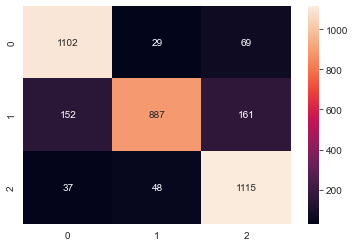

In [135]:
cm= confusion_matrix(y_test, y_pred)  

print(cm)

sns.heatmap(cm, annot=True, fmt="d")

From the confusion matrix, we can see that some of the reviews are wrongly classified: 
- Around 6% of the negative reviews are wrongly classified as positive
- Around 2.4% of the negative reviews are wrongly classified as neutral 

These are the wrong classifications that we have to look out for as the cost of not detecting a negative reviews can be significant. Correctly identifying negative reviews is essential for a hotel to rectify the problems promptly and understand the areas to focus on. This can lead to higher efficiency and better service, which in turn, encourages hotel guests to return.

Nonetheless the model still does a good job in correctly identifying the majority of the reviews.

### Saving Model for Future Usage

In [139]:
with open('Sentiment_model', 'wb') as files:
    pickle.dump(svm, files)

In [3]:
# load saved model
with open('Sentiment_model' , 'rb') as f:
    clf = pickle.load(f)

In [4]:
# Trying out the model 
example = ['i am horrible']
result = clf.predict(example)

print(result)

[0]


In [5]:
# Define a function to convert the model output in integer to an interpretable statement
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Neutral Sentiment.")
    else:
        print("Input statement has Positive Sentiment.")

In [6]:
expression_check(2)

Input statement has Positive Sentiment.


In [89]:
# function to take the input statement and perform the same transformations we did earlier
def sentiment_predictor(text):
    text = preprocess_text(text)
    result = clf.predict(text)
    return expression_check(result)

In [90]:
text = ['This youtiao is so delicious']
sentiment_predictor(text)

Input statement has Positive Sentiment.
